# VGG-19-Based Model Architecture

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load datasets created in pre-processing

In [4]:
data_dir = '/content/drive/My Drive/processed_data/final_hope'

X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy'))

In [ ]:
X_train.shape, y_train.shape

((13149, 224, 224, 3), (13149, 5))

### Define model architecture


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Lambda, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


def create_saliency_network(input_shape):
    """
    The saliency network is structured with an encoder-decoder architecture to generate a saliency map from the input images,
    emphasising features critical for age differentiation.
    This network begins with consecutive convolutional and max pooling layers to downsample the input,
    follows with a bottleneck layer, and concludes with upsampling layers merged with the corresponding earlier layers to reconstruct the feature space,
    outputting a saliency map.

    """
    inputs = Input(shape=input_shape)

    # Encoder: downsample the input
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder: upsample the feature map
    up1 = UpSampling2D((2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    up2 = UpSampling2D((2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)

    # Output a saliency map and replicate it across three channels
    saliency_output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    replicated_output = Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1))(saliency_output)

    model = Model(inputs=inputs, outputs=replicated_output)
    return model

def create_age_model(input_shape):

    """
    Constructs deep learning model for age classification using the saliency network and a VGG19 base model.
    The VGG19 model, pre-trained on ImageNet and modified in the last 'N' layers for trainability,
    processes the output from the saliency network.
    Additional convolutional, normalization, and dropout layers refine the features.
    The model concludes with dense layers that feature dropout and L2 regularization to predict age across five categories,
    utilizing the refined features for accurate classification.

    """
    # Saliency model
    saliency_model = create_saliency_network(input_shape)

    # Base VGG19 model
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    N = 8
    for layer in base_model.layers[-N:]:
     layer.trainable = True

    # Connect the output of the saliency network to the input of the VGG19 base model
    vgg_output = base_model(saliency_model.output)

    # Additional Convolutional Layer for further feature refinement
    conv_layer = Conv2D(256, (3, 3), activation='relu', padding='same')(vgg_output)
    batch_norm = BatchNormalization()(conv_layer)
    dropout_layer = Dropout(0.5)(batch_norm)

    # Flatten and dense layers for age prediction
    flat_features = Flatten()(dropout_layer)
    lri_features = Dense(2058, activation='relu',kernel_regularizer=l2(0.005))(flat_features)  # Simulating LRI
    dr_reg1 = Dropout(0.25)(lri_features)
    dense1 = Dense(1024, activation='relu',kernel_regularizer=l2(0.005))(dr_reg1)
    dr_reg2 = Dropout(0.25)(dense1)
    age_output = Dense(5, activation='softmax', name='age_output')(dr_reg2)

    model = Model(inputs=saliency_model.input, outputs=age_output)
    return model


# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use this augmented data in training
train_generator = datagen.flow(
    X_train,y_train,
    batch_size=32,
)

# Setup checkpoint directory
checkpoint_filepath = '/tmp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)


# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Update your model instantiation and compilation
model = create_age_model((224, 224, 3))
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001)


model.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)         

### Fit the model on training data using the defined callbacks

In [ ]:
history = model.fit(train_generator,
                    epochs=25,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_callback,early_stopping,reduce_lr])


Epoch 1/25
411/411 [==============================] - ETA: 0s - loss: 21.2446 - accuracy: 0.2860
Epoch 1: val_loss improved from inf to 16.94144, saving model to /tmp/checkpoint
411/411 [==============================] - 323s 686ms/step - loss: 21.2446 - accuracy: 0.2860 - val_loss: 16.9414 - val_accuracy: 0.3358 - lr: 1.0000e-04
Epoch 2/25
411/411 [==============================] - ETA: 0s - loss: 13.6835 - accuracy: 0.3999
Epoch 2: val_loss improved from 16.94144 to 10.84435, saving model to /tmp/checkpoint
411/411 [==============================] - 246s 598ms/step - loss: 13.6835 - accuracy: 0.3999 - val_loss: 10.8444 - val_accuracy: 0.4928 - lr: 1.0000e-04
Epoch 3/25
411/411 [==============================] - ETA: 0s - loss: 8.8408 - accuracy: 0.4945
Epoch 3: val_loss improved from 10.84435 to 7.04869, saving model to /tmp/checkpoint
411/411 [==============================] - 246s 598ms/step - loss: 8.8408 - accuracy: 0.4945 - val_loss: 7.0487 - val_accuracy: 0.5317 - lr: 1.0000e-0

### Store model in Google Drive

In [ ]:
model.save('/content/drive/My Drive/processed_data/NewLayer_Hopium.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Visualize training process

Loss and validation loss follow the same pattern and plateau after around 15 epochs.

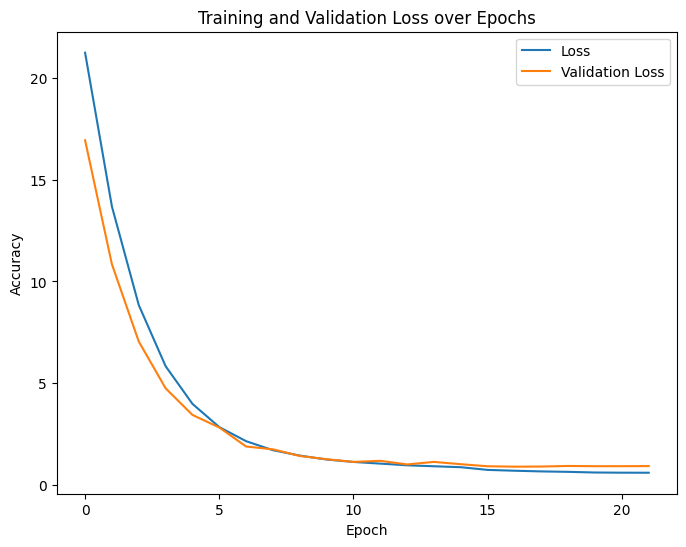

In [ ]:
train_accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

# Plotting both training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Loss')
plt.plot(val_accuracy, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plot tracking training- and validation accuracy implies some level of overfitting, particualrly after epoch 15.

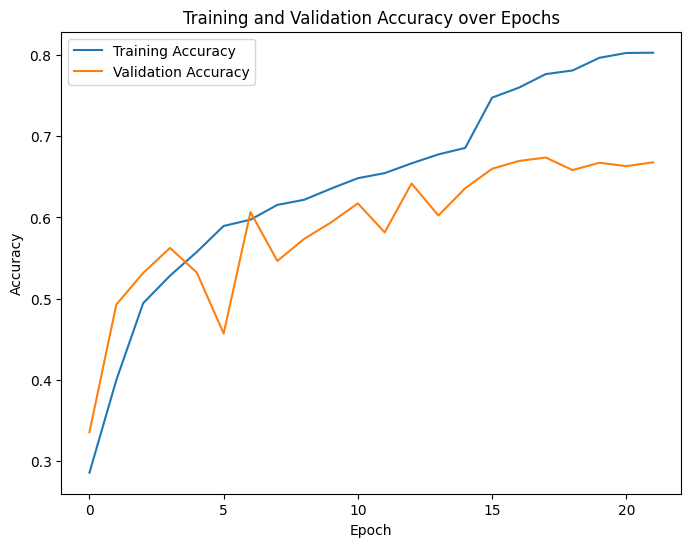

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotting both training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load model again if necessary (e.g. if runtime disconnects)

In [5]:
#from keras.models import load_model
#model = load_model('/content/drive/My Drive/processed_data/NewLayer_Hopium.h5')

### Predict on test data

In [6]:
predictions = model.predict(X_test)
predicted_ages = np.argmax(predictions, axis=1)
true_ages = np.argmax(y_test, axis=1)

118/118 [==============================] - 1202s 10s/step


### Compute accuracy scores and create confusion matrices

In [7]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_ages, predicted_ages)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6718126164492947


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4')])

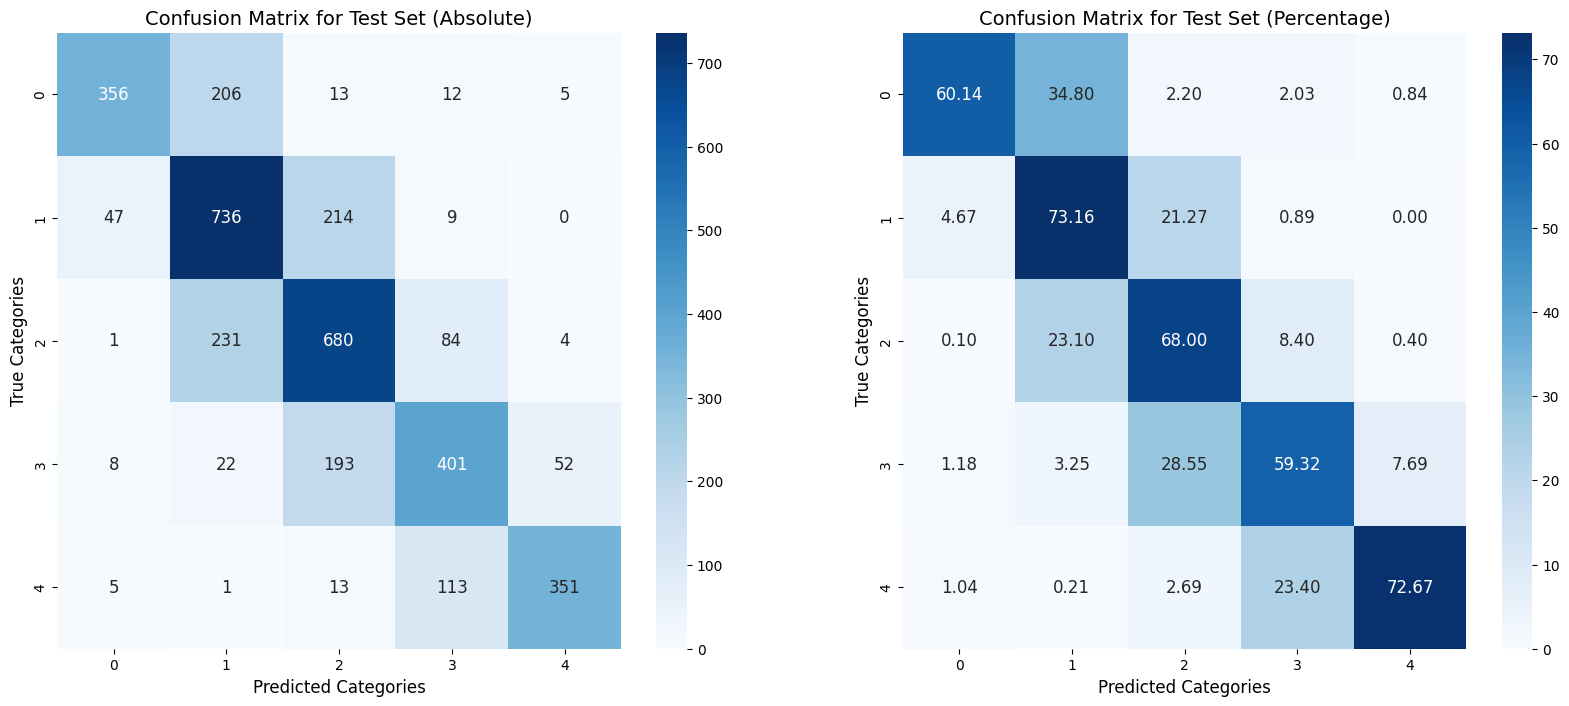

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(true_ages, predicted_ages)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize by row and convert to percentage

# Set up the matplotlib figure
plt.figure(figsize=(20, 8))  # Increase the overall figure size

# Plot the absolute value confusion matrix
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size':12})  # Increase annotation font size
plt.title('Confusion Matrix for Test Set (Absolute)', fontsize=14)
plt.xlabel('Predicted Categories', fontsize=12)
plt.ylabel('True Categories', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Plot the percentage confusion matrix
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', annot_kws={'size':12})  # Increase annotation font size
plt.title('Confusion Matrix for Test Set (Percentage)', fontsize=14)
plt.xlabel('Predicted Categories', fontsize=12)
plt.ylabel('True Categories', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


[[356 206  13  12   5]
 [ 47 736 214   9   0]
 [  1 231 680  84   4]
 [  8  22 193 401  52]
 [  5   1  13 113 351]]


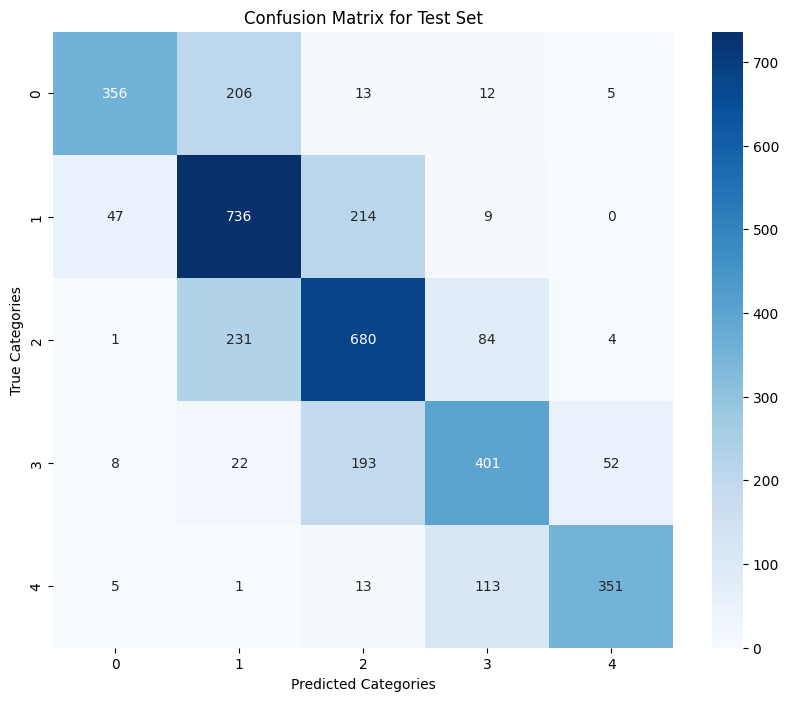

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_ages, predicted_ages)
print(cm)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Categories')
plt.ylabel('True Categories')
plt.show()

In [ ]:
# Calculate class-wise accuracy and round it to two decimal places
class_accuracies = np.round(cm.diagonal() / cm.sum(axis=1), 4)

class_accuracies

array([0.6014, 0.7316, 0.68  , 0.5932, 0.7267])

In [ ]:
import tensorflow as tf

def one_off_accuracy(y_true, y_pred):

    # Compute the absolute difference between true and predicted classes
    abs_diff = tf.abs(y_true - y_pred)

    # Check if the prediction is exact or off by one
    correct_or_one_off = tf.cast(tf.less_equal(abs_diff, 1), tf.float32)

    # Compute the mean accuracy of being correct or one-off
    return tf.reduce_mean(correct_or_one_off)

one_off_accuracy(predicted_ages, true_ages)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9752462>

### Display some images and their true- and predicted class

1/1 [==============================] - 3s 3s/step


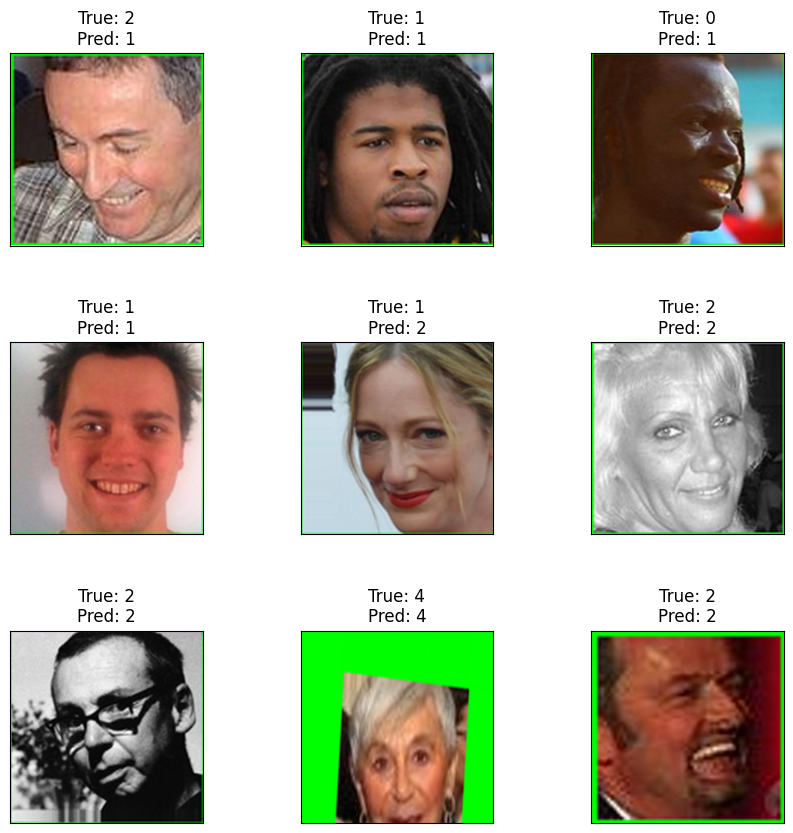

In [ ]:
# Randomly select 9 images from the test dataset
num_images = 9
random_indices = np.random.choice(X_test.shape[0], num_images, replace=False)
sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]

# Predict classes using the model
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(sample_images[i])

    # True label
    true_label = np.argmax(sample_labels[i])

    # Prediction
    predicted_label = predicted_classes[i]

    # Set title
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()